In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn                import preprocessing 
from sklearn.metrics        import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import Lasso,Ridge

from sktime.forecasting.theta               import ThetaForecaster
from sktime.forecasting.fbprophet           import Prophet
from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.exp_smoothing       import ExponentialSmoothing
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster,ForecastingPipeline
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender
from sktime.forecasting.model_selection     import temporal_train_test_split
from sktime.forecasting.trend               import PiecewiseLinearTrendForecaster
from sktime.forecasting.compose             import make_reduction

from sktime.split import ExpandingGreedySplitter

from hyperopt import fmin, hp, tpe
from hyperopt import SparkTrials, STATUS_OK, Trials
from scipy.optimize import minimize

import warnings

In [232]:
data = pd.read_csv("../../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

data.index = pd.to_datetime(data['Timestamp'],utc=True)
data.index = data.index.tz_localize(None)  
data["y"] = data["NE7_GWh"].values
data = data.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])
data.index = pd.period_range(start=data.index[0], end= data.index[-1], freq="M")

#split data
#don't use stride (step_length=5).Keeps last splitt completely unseen. Test_size fixed by task
splitter = ExpandingGreedySplitter(test_size=12, folds=4)  # step_length=5, 
splits = list(splitter.split(data))

In [233]:
#Let's add hyperparameter tuning for simple forecasters
def hyperParameterTuningSimpleForecaster(forecaster,search_space,data,splits,max_evals=30,timeout=5*60):
    "Wrapper around hyperparameter tuning of any forecaster."

    def set_forecaster(forecaster):
        def train(params):
            """
            Main training function. Here we train the simple models and later select the ones
            which perform best over all splits. 
            """
            f = forecaster(**params)
            metrics = []

            for split in splits[:-1]:
                y_train = data.iloc[split[0]]
                y_test  = data.iloc[split[1]]            
                idx = pd.period_range(start=y_test.index[0], end= y_test.index[-1], freq="M")
                prediction = f.fit_predict(y_train, fh=ForecastingHorizon(idx, is_relative=False))
                metrics.append(mean_absolute_error(y_test,prediction))
            return {"loss": np.median(metrics), "status": STATUS_OK, "Trained_Model": f}
        
        return train
    
    train_forecaster=set_forecaster(forecaster)
    algorithm = tpe.suggest #Tree of Parzen Estimators, a Bayesian method
    hyperTrials = Trials()
    hyperparameters = fmin(
                           fn=train_forecaster,
                           space=search_space,
                           algo=algorithm,
                           trials=hyperTrials,
                           max_evals=max_evals,
                           timeout=timeout   #seconds
                           ) 
    bestModel = hyperTrials.results[np.argmin([r["loss"] for r in hyperTrials.results])]["Trained_Model"]
    return bestModel

In [234]:
warnings.filterwarnings('ignore')

prophet_search_space = {
"seasonality_mode":        hp.choice("seasonality_mode",["multiplicative", "additive"]),
"changepoint_range":       hp.uniform("changepoint_range", 0.8, 0.95),             # optional according to docs, default = 0.8
"changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69),  # according to recom. same as [0.001,0.5]
"seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),    # according to recom. same as [0.001, 10]
#"holidays_prior_scale":    hp.loguniform("holidays_prior_scale", -6.9, 2.3),       # according to recom. same as [0.001, 10]
#"add_country_holidays":    hp.choice("holidays",[None,{'country_name': 'Switzerland'}]),
}

exp_search_space= {
                    "trend":        hp.choice("trend",["additive", "multiplicative", None]),
                    "seasonal":     hp.choice("seasonal",["additive", "multiplicative", None]),
                    "sp": 12
                }

theta_search_space = {"deseasonalize": hp.choice("deseasonalize",[True, False]),
                      "sp": 12}



simple_forecasters = {
    "prophet": [Prophet,prophet_search_space],
    "theta":[ThetaForecaster,theta_search_space],
    "exp":[ExponentialSmoothing,exp_search_space],
}

In [235]:
#tune hyperparams of simple models
simple_models = {}
for name,f_or_space in simple_forecasters.items():
    simple_models[name] = hyperParameterTuningSimpleForecaster(f_or_space[0],f_or_space[1],data,splits,max_evals=5)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

17:18:24 - cmdstanpy - INFO - Chain [1] start processing

17:18:25 - cmdstanpy - INFO - Chain [1] done processing

17:18:25 - cmdstanpy - INFO - Chain [1] start processing

17:18:25 - cmdstanpy - INFO - Chain [1] done processing

17:18:25 - cmdstanpy - INFO - Chain [1] start processing

17:18:25 - cmdstanpy - INFO - Chain [1] done processing



 20%|██        | 1/5 [00:01<00:05,  1.35s/trial, best loss: 3.739461024656601]

17:18:26 - cmdstanpy - INFO - Chain [1] start processing

17:18:26 - cmdstanpy - INFO - Chain [1] done processing

17:18:26 - cmdstanpy - INFO - Chain [1] start processing

17:18:27 - cmdstanpy - INFO - Chain [1] done processing

17:18:27 - cmdstanpy - INFO - Chain [1] start processing

17:18:27 - cmdstanpy - INFO - Chain [1] done processing



 40%|████      | 2/5 [00:03<00:04,  1.61s/trial, best loss: 3.739461024656601]

17:18:27 - cmdstanpy - INFO - Chain [1] start processing

17:18:28 - cmdstanpy - INFO - Chain [1] done processing

17:18:28 - cmdstanpy - INFO - Chain [1] start processing

17:18:29 - cmdstanpy - INFO - Chain [1] done processing

17:18:29 - cmdstanpy - INFO - Chain [1] start processing

17:18:30 - cmdstanpy - INFO - Chain [1] done processing



 60%|██████    | 3/5 [00:05<00:03,  1.95s/trial, best loss: 3.739461024656601]

17:18:30 - cmdstanpy - INFO - Chain [1] start processing

17:18:30 - cmdstanpy - INFO - Chain [1] done processing

17:18:30 - cmdstanpy - INFO - Chain [1] start processing

17:18:31 - cmdstanpy - INFO - Chain [1] done processing

17:18:31 - cmdstanpy - INFO - Chain [1] start processing

17:18:31 - cmdstanpy - INFO - Chain [1] done processing



 80%|████████  | 4/5 [00:07<00:01,  1.79s/trial, best loss: 3.739461024656601]

17:18:31 - cmdstanpy - INFO - Chain [1] start processing

17:18:32 - cmdstanpy - INFO - Chain [1] done processing

17:18:32 - cmdstanpy - INFO - Chain [1] start processing

17:18:32 - cmdstanpy - INFO - Chain [1] done processing

17:18:32 - cmdstanpy - INFO - Chain [1] start processing

17:18:33 - cmdstanpy - INFO - Chain [1] done processing



100%|██████████| 5/5 [00:01<00:00,  3.82trial/s, best loss: 3.1150725012865834]


In [236]:
simple_models

{'prophet': Prophet(changepoint_prior_scale=0.0028205199591073513,
         changepoint_range=0.8834197958462839, seasonality_mode='multiplicative',
         seasonality_prior_scale=0.47976522937886745),
 'theta': ThetaForecaster(sp=12),
 'exp': ExponentialSmoothing(seasonal='additive', sp=12, trend='additive')}

In [237]:
#define a few composite forecasters
arima = TransformedTargetForecaster([
            ("detrend",         Detrender(forecaster=PiecewiseLinearTrendForecaster())),
            ("deseasonalize",   Deseasonalizer(model="additive", sp=12)),
            ("forecast",        ARIMA())  
                                    ])

random_forest = TransformedTargetForecaster([
            ("detrend",   Detrender(forecaster=PiecewiseLinearTrendForecaster())),
            ("forecast",  make_reduction(RandomForestRegressor(), window_length=12, strategy="recursive") )  
                                    ])

composite_models= {
              "arima with pwl-detrend": arima,
              "random forest with pwl-detrend" : random_forest,
              }

In [238]:

def createPredictions(forecasters,fh):
    """returns Dataframe(columns = [y_pre_forecaster_1, ...y_pre_forecaster_i])
    for a given list of forecasters. 
    """
    dict = {}
    for name,forecaster in forecasters.items():
        prediction = forecaster.predict(fh=horizon)
        dict[name]= np.array(prediction.values).flatten()

    df = pd.DataFrame(dict)
    df.index = prediction.index
    return df

#create predictions for all splits
for i,split in enumerate(splits):
    y_train_split = data.iloc[split[0]]
    y_test_split = data.iloc[split[1]]

    idx = pd.period_range(start=y_test_split.index[0], 
                          end= y_test_split.index[-1], 
                          freq="M")
    horizon = ForecastingHorizon(idx, is_relative=False)

    #first predict with the tuned simple models
    globals()[f"predictions_split_{i}"] = createPredictions(simple_models,horizon)
    
    #add the predictions from the composite models, they need training first.
    for name,model in composite_models.items():
        model.fit(y_train_split)
        globals()[f"predictions_split_{i}"][name] = model.predict(horizon)

17:18:35 - cmdstanpy - INFO - Chain [1] start processing

17:18:35 - cmdstanpy - INFO - Chain [1] done processing

17:18:35 - cmdstanpy - INFO - Chain [1] start processing

17:18:36 - cmdstanpy - INFO - Chain [1] done processing

17:18:36 - cmdstanpy - INFO - Chain [1] start processing

17:18:37 - cmdstanpy - INFO - Chain [1] done processing

17:18:37 - cmdstanpy - INFO - Chain [1] start processing

17:18:37 - cmdstanpy - INFO - Chain [1] done processing

17:18:38 - cmdstanpy - INFO - Chain [1] start processing

17:18:38 - cmdstanpy - INFO - Chain [1] done processing

17:18:38 - cmdstanpy - INFO - Chain [1] start processing

17:18:39 - cmdstanpy - INFO - Chain [1] done processing

17:18:39 - cmdstanpy - INFO - Chain [1] start processing

17:18:40 - cmdstanpy - INFO - Chain [1] done processing

17:18:40 - cmdstanpy - INFO - Chain [1] start processing

17:18:40 - cmdstanpy - INFO - Chain [1] done processing



In [239]:
def createEnsembleSingleSplit(y_test,dfPredictions):
    """
    Compute the optimal,strictly positive weights for one split e.g one set of 
    y_test, predictions = dataframe(columns = [y_pre_forecaster_1, ...y_pre_forecaster_i])
    """
    
    if "ensemble" in dfPredictions.columns:
        dfPredictions = dfPredictions.drop(columns=["ensemble"])

    def loss_func(weights):
        fc = np.sum(dfPredictions*np.array(weights),axis=1)
        return mean_squared_error(y_test,fc) 


    opt_weights = minimize(
                        loss_func, 
                        x0=[1/len(dfPredictions.columns)]*len(dfPredictions.columns),
                        constraints=[{'type':'eq','fun':lambda w: 1-sum(w)}], 
                        method='SLSQP', 
                        bounds=[(0.0,1.0)]*len(dfPredictions.columns),
                        options={'ftol':1e-10}
                        )

    dfWeights = pd.DataFrame(np.round_(opt_weights.x,3),
                            index=dfPredictions.columns,
                            columns=['opt_weight']
                            )

    weights = dfWeights["opt_weight"].to_dict()
    return weights

def computePredictionSingleSplit(weights,dfPredictions):
    return dfPredictions[weights.keys()].mul(weights.values()).sum(axis=1)


weights_list = []
mae = []

#don't use the last split for the ensemble building.
for i,split in enumerate(splits[:-1]):
    y_train = data.iloc[split[0]]
    y_test  = data.iloc[split[1]]
    predictions = globals()[f"predictions_split_{i}"]
    weights = createEnsembleSingleSplit(y_test,predictions)
    predictions["ensemble"] =  computePredictionSingleSplit(weights,predictions)
    mae.append(mean_absolute_error(y_test,predictions["ensemble"]))
    weights_list.append(weights)

dfweights = pd.DataFrame(weights_list)
dfweights["mae"] = mae

In [240]:
averagedWeights = np.average(a=dfweights.drop(columns=['mae']), weights=dfweights['mae'], axis=0)
averagedWeights = pd.DataFrame(averagedWeights,index=dfweights.drop(columns=['mae']).columns).to_dict()[0]
averagedWeights

{'prophet': 0.2562376011390068,
 'theta': 0.08558102084171386,
 'exp': 0.42796527398382034,
 'arima with pwl-detrend': 0.23021610403545906,
 'random forest with pwl-detrend': 0.0}

In [241]:
predictions = predictions_split_3.copy()
#predictions = predictions.drop(columns=["ensemble"]) #remove the optimal ensemble for this split
predictions["averaged_ensemble"] =  computePredictionSingleSplit(averagedWeights,predictions)

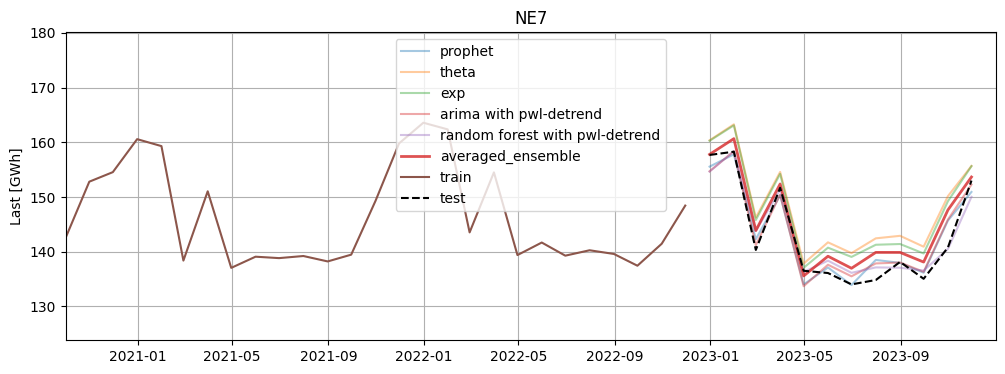

In [242]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

for name in predictions.columns:
    if name == "averaged_ensemble":
        axes.plot(predictions[name].index.to_timestamp(freq="M"), 
              predictions[name].values, color="tab:red", 
              linewidth=2,label=name, alpha=0.8)
    else:
        axes.plot(predictions[name].index.to_timestamp(freq="M"), 
                predictions[name].values, label=name, alpha=0.4)

#plot last split which was not used in model building
for i,split in enumerate(splits[-1:]):
    y_train = data.iloc[split[0]]
    y_test  = data.iloc[split[1]]
    axes.plot(y_train.index.to_timestamp(freq="M"), 
              y_train.values, label="train")
    
    axes.plot(y_test.index.to_timestamp(freq="M"), 
              y_test.values, label="test",color="black", linestyle="--")
    
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")

axes.set_xlim([pd.Timestamp(2020,10,1),pd.Timestamp(2023,12,31)])
axes.grid()
plt.show()

In [243]:
predictions["averaged_ensemble"]

2022-12    157.787862
2023-01    160.668167
2023-02    143.879170
2023-03    152.386704
2023-04    135.578687
2023-05    139.177884
2023-06    136.977591
2023-07    139.878829
2023-08    139.874220
2023-09    138.113244
2023-10    147.640220
2023-11    153.658077
Freq: M, Name: averaged_ensemble, dtype: float64

In [244]:
#Next: 
# Test the windowed approach with a fixed window size, meaning a non expanding window.
# Add hyperopt for the models. Take hyperparams which are best on the average or the median of the splits.